In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import  Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV3Small
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
train_dir = 'C:/Users/Corrupted/Desktop/S_output/train'
test_dir = 'C:/Users/Corrupted/Desktop/S_output/test'
val_dir = 'C:/Users/Corrupted/Desktop/S_output/val'

In [3]:
class_name = []
for image_class in os.listdir(train_dir):
    class_name.append(image_class)
print(class_name)
print(f'Total class_name: {len(class_name)}')

['S_Bad', 'S_Good']
Total class_name: 2


In [4]:
train_data = image_dataset_from_directory(train_dir, label_mode="binary",
                                          image_size=(224, 224), batch_size=32,
                                          # color_mode='grayscale',
                                          shuffle=True, seed=42)
test_data = image_dataset_from_directory(test_dir, label_mode="binary",
                                         image_size=(224, 224), batch_size=32,
                                         # color_mode='grayscale',
                                         shuffle=False, seed=42)
val_data = image_dataset_from_directory(val_dir, label_mode="binary",
                                        image_size=(224, 224), batch_size=32,
                                        # color_mode='grayscale',
                                        shuffle=False, seed=42)

Found 1864 files belonging to 2 classes.
Found 269 files belonging to 2 classes.
Found 532 files belonging to 2 classes.


In [5]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6,
                                              min_delta=0.0001)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2,
                                                 patience=4, min_lr=1e-7)


In [6]:

input_shape = (224, 224, 3)
n_class = len(class_name)

base_model = MobileNetV3Small(
    weights='imagenet', include_top=False, input_shape=input_shape)
x = base_model.output

x = GlobalAveragePooling2D()(x)

x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)

preds = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=preds)

for layers in model.layers[:-5]:
    layers.trainable = False

model.summary()

4334752/4334752 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                               

In [7]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

In [8]:
hist = model.fit(train_data, epochs=100, validation_data=val_data,
                 callbacks=[early_stop, reduce_lr])

Epoch 1/100
59/59 [==============================] - 57s 768ms/step - loss: 0.4304 - accuracy: 0.7929 - val_loss: 0.3434 - val_accuracy: 0.8553 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 46s 724ms/step - loss: 0.3317 - accuracy: 0.8573 - val_loss: 0.3660 - val_accuracy: 0.8477 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 47s 726ms/step - loss: 0.3116 - accuracy: 0.8680 - val_loss: 0.3236 - val_accuracy: 0.8703 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 44s 690ms/step - loss: 0.2858 - accuracy: 0.8814 - val_loss: 0.3331 - val_accuracy: 0.8759 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 46s 715ms/step - loss: 0.2896 - accuracy: 0.8788 - val_loss: 0.3944 - val_accuracy: 0.8534 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 45s 710ms/step - loss: 0.2682 - accuracy: 0.8863 - val_loss: 0.4046 - val_accuracy: 0.8590 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 45s 7

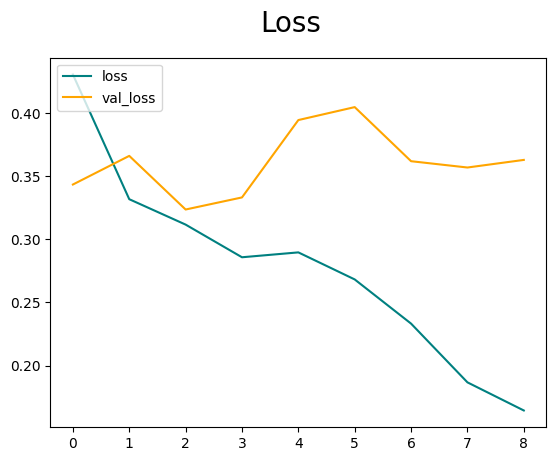

In [9]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

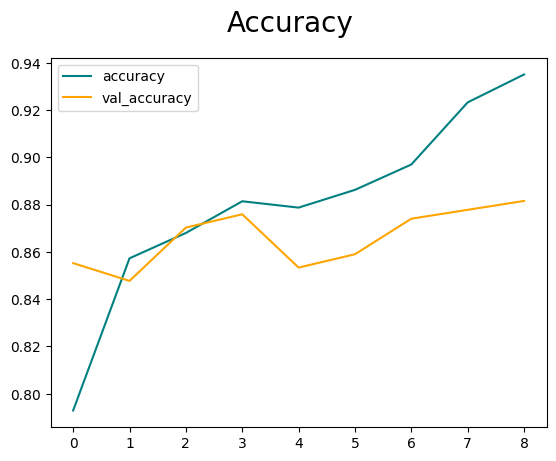

In [10]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'],
         color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [11]:
test_loss, test_acc = model.evaluate(test_data)
print(f'Test Loss: {test_loss} Test Accuracy: {test_acc}')

9/9 [==============================] - 3s 258ms/step - loss: 0.3841 - accuracy: 0.8550
Test Loss: 0.3841346800327301 Test Accuracy: 0.8550186157226562


In [12]:
y_pred = model.predict(test_data)

9/9 [==============================] - 3s 253ms/step


1/1 [==============================] - 1s 714ms/step


<AxesSubplot: >

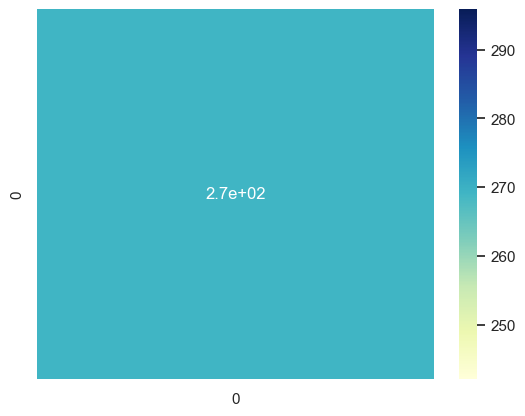

In [13]:
sns.set()
y_pred = []
for x, y in test_data:
    y_pred.extend(np.argmax(model.predict(x), axis=1).tolist())

# obtain true class labels
y_true = []
for x, y in test_data:
    y_true.extend(np.argmax(y, axis=1).tolist())

# calculate confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

sns.heatmap(conf_mat, annot=True, cmap="YlGnBu")

In [14]:
print(f"Training Accuracy: {hist.history['accuracy'][-1]}")
print(f"Validation Accuracy: {hist.history['val_accuracy'][-1]}")

Training Accuracy: 0.9350858330726624
Validation Accuracy: 0.8815789222717285
